In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9916.21218117854

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 01:31:00,7430.00,7457.25,7428.50,7453.00,5390,9817
1,2019-04-01 02:52:00,7452.75,7472.50,7450.50,7465.25,6301,10043
2,2019-04-01 04:24:00,7465.25,7479.25,7463.25,7477.75,6230,9659
3,2019-04-01 07:16:00,7477.75,7487.50,7473.25,7475.00,6320,10275
4,2019-04-01 09:17:00,7475.25,7478.25,7469.25,7472.50,5880,9943
...,...,...,...,...,...,...,...
4820,2019-09-04 17:11:00,7681.00,7686.75,7676.25,7685.50,5166,10140
4821,2019-09-04 17:28:00,7685.75,7691.00,7679.50,7688.50,4512,9468
4822,2019-09-04 17:42:00,7688.75,7702.75,7688.75,7701.25,5233,11112


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                    'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
data.set_index('date', inplace=True)
data

,open,close,max,min,mid
date,,,,,
2019-04-01 01:31:00,7430.00,7453.00,NaN,NaN,NaN
2019-04-01 02:52:00,7452.75,7465.25,NaN,NaN,NaN
2019-04-01 04:24:00,7465.25,7477.75,NaN,NaN,NaN
2019-04-01 07:16:00,7477.75,7475.00,NaN,NaN,NaN
2019-04-01 09:17:00,7475.25,7472.50,NaN,NaN,NaN
...,...,...,...,...,...
2019-09-04 17:11:00,7681.00,7685.50,7726.0,7594.25,7660.125
2019-09-04 17:28:00,7685.75,7688.50,7726.0,7594.25,7660.125
2019-09-04 17:42:00,7688.75,7701.25,7726.0,7594.25,7660.125


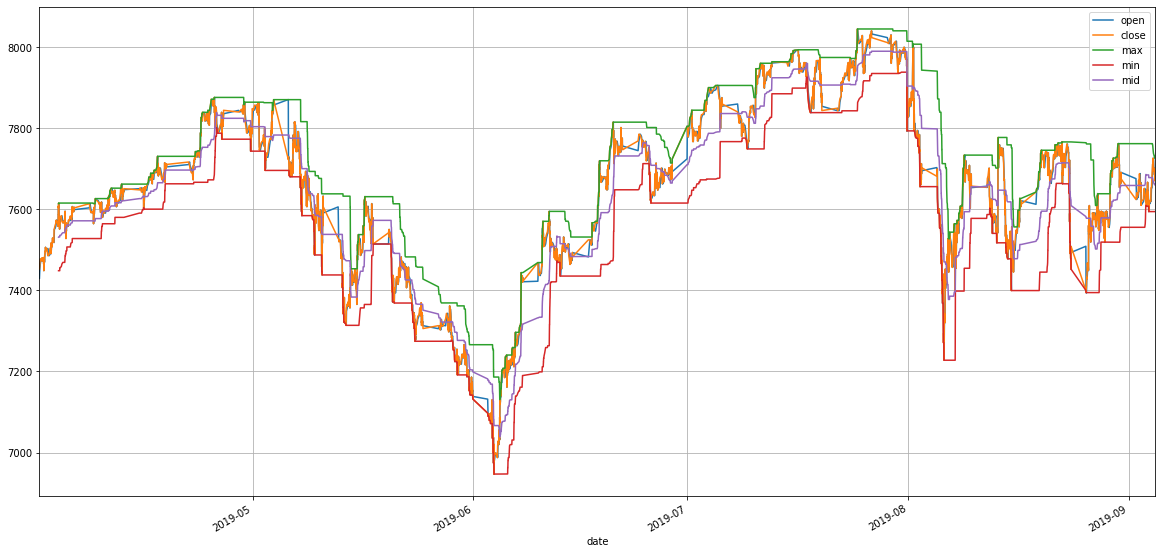

In [7]:
data.plot(figsize=(20,10), grid=True);

In [8]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()

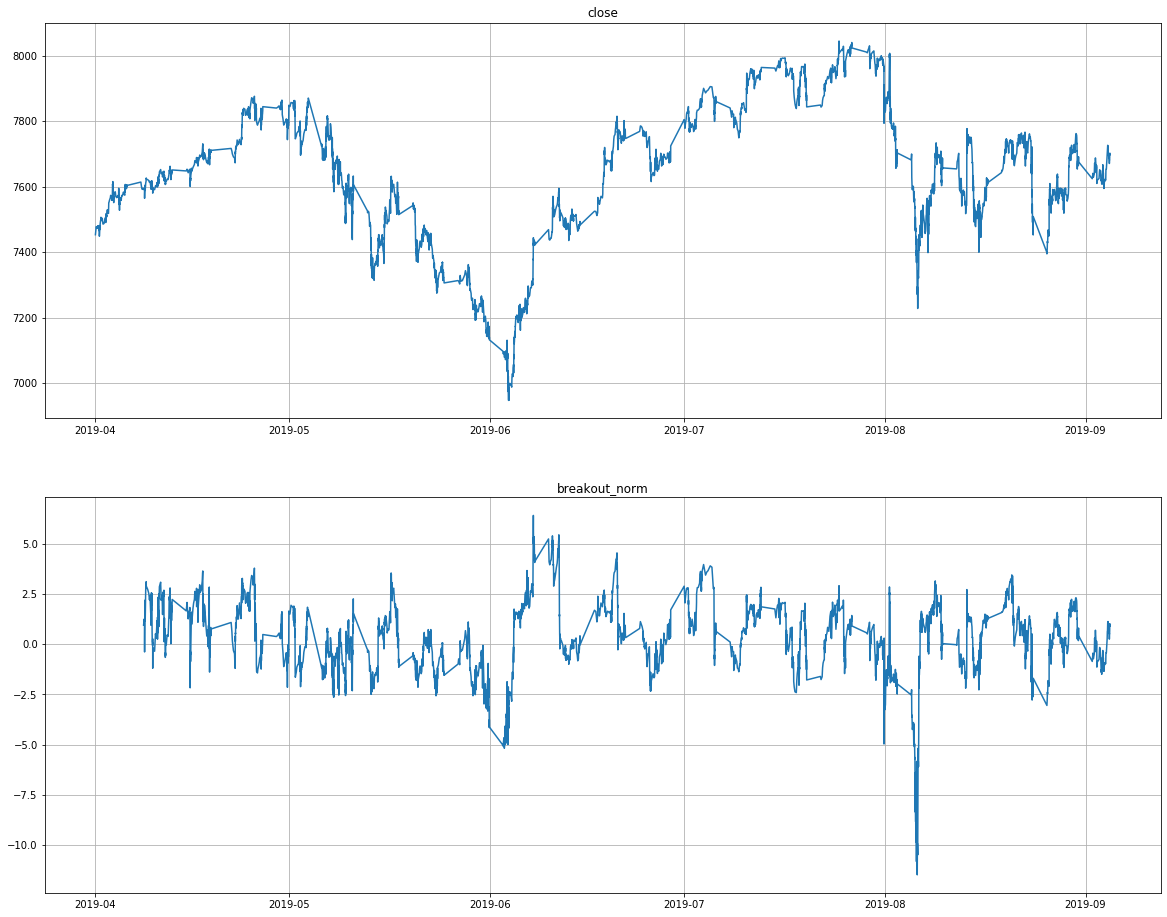

In [9]:
plot(data[['close', 'breakout_norm']])

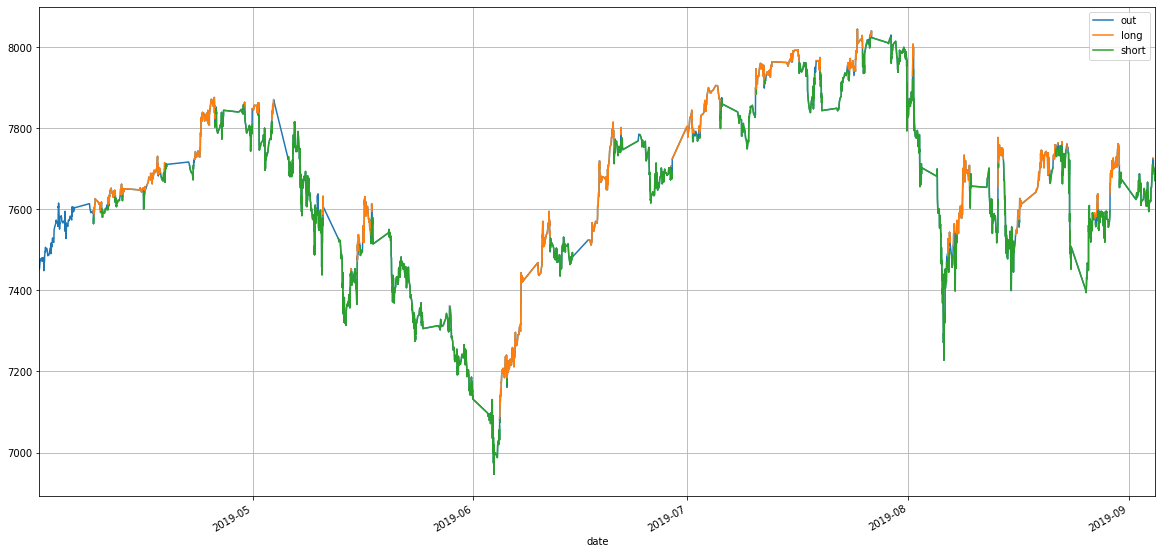

In [10]:
chart_price(data.close, data.breakout_norm, 1, 1)

Annual return          0.302150
Cumulative returns     0.119800
Annual volatility      0.399422
Sharpe ratio           0.856563
Calmar ratio           1.949294
Stability              0.550367
Max drawdown          -0.155005
Omega ratio            1.164596
Sortino ratio          1.419051
Skew                   0.811366
Kurtosis               2.564567
Tail ratio             1.159254
Daily value at risk   -0.048965
dtype: float64

Win percent                 0.244131
Average gain              944.519231
Average loss             -267.888199
Avg Win/avg loss ratio      3.525796
Transaction EV             28.098592
Number of transactions    213.000000
Per day trades              3.953704
Per trade days              0.252927
dtype: float64


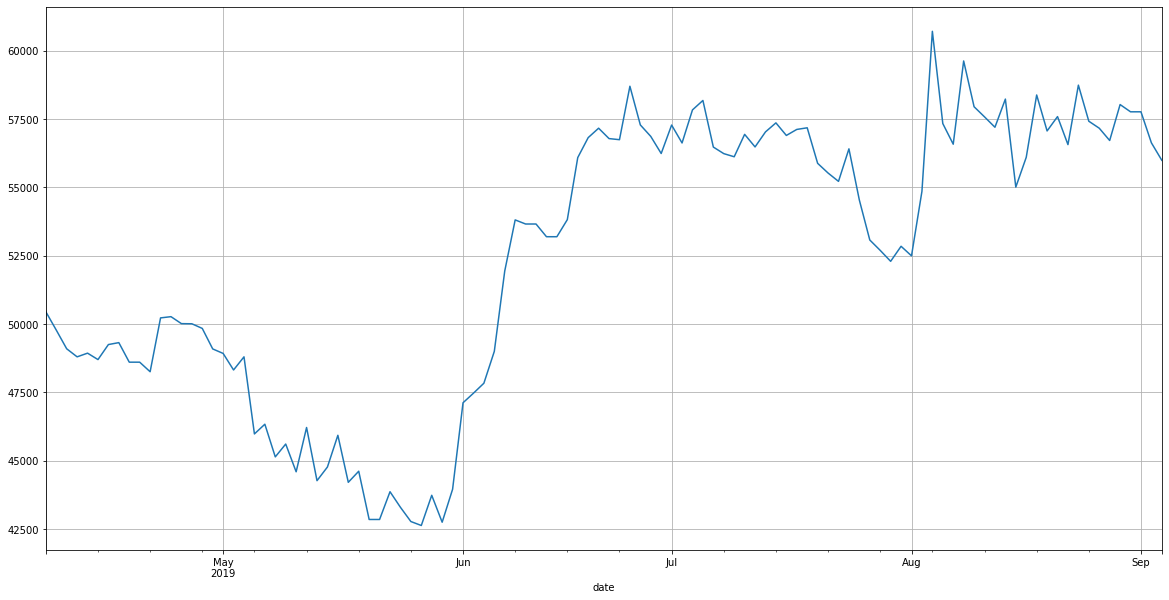

In [11]:
backtest(data.open.iloc[200:].copy(), data.breakout_norm.iloc[200:].copy(), 1, 20, 50000)